In [2]:
import scanpy as sc 
import pandas as pd 
import numpy as np
import anndata as ad

file_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices" #1k dataset
adata_dict = {}
for i in range(1, 13): 
    adata_dict[i] = sc.read_h5ad(f"{file_path}/adata_{i}.h5ad")

## Plotting adata_5 vs. adata_12

### With all genes

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)


def compute_non_unif_estimator(umi_prob_arr, n_umis_true,j):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == 4**j, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return 4**j - np.sum( (1-umi_prob_arr)**n_umis_true )

umi_probs = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=None)
umi_probs.columns = ['umi', 'prob']

umi_prob_arr = np.array(umi_probs['prob'])
    
    
def compute_naive_unif_estimator(n_umis_true, j):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return 4**j * (1 - (1 - 1 / 4**j)**n_umis_true)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Extract gene matrix for common barcodes
genes = np.array(adata_dict[i].var_names)
barcode_list = list(common_barcodes)
i_indices = [adata_dict[i].obs_names.get_loc(b) for b in barcode_list]
j_indices = [adata_dict[j].obs_names.get_loc(b) for b in barcode_list]

# Pull full matrices at once
X_i = adata_dict[i].X[i_indices]
X_j = adata_dict[j].X[j_indices]

# Create mask for gene_counts_i that are greater than or equal to 1
mask = X_i >= 1

# Filter using the mask
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays (already are, but for consistency)
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]


Total common barcodes: 1232
Total filtered gene counts: 4283561


/tmp/ipykernel_3661160/209598446.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_3661160/209598446.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


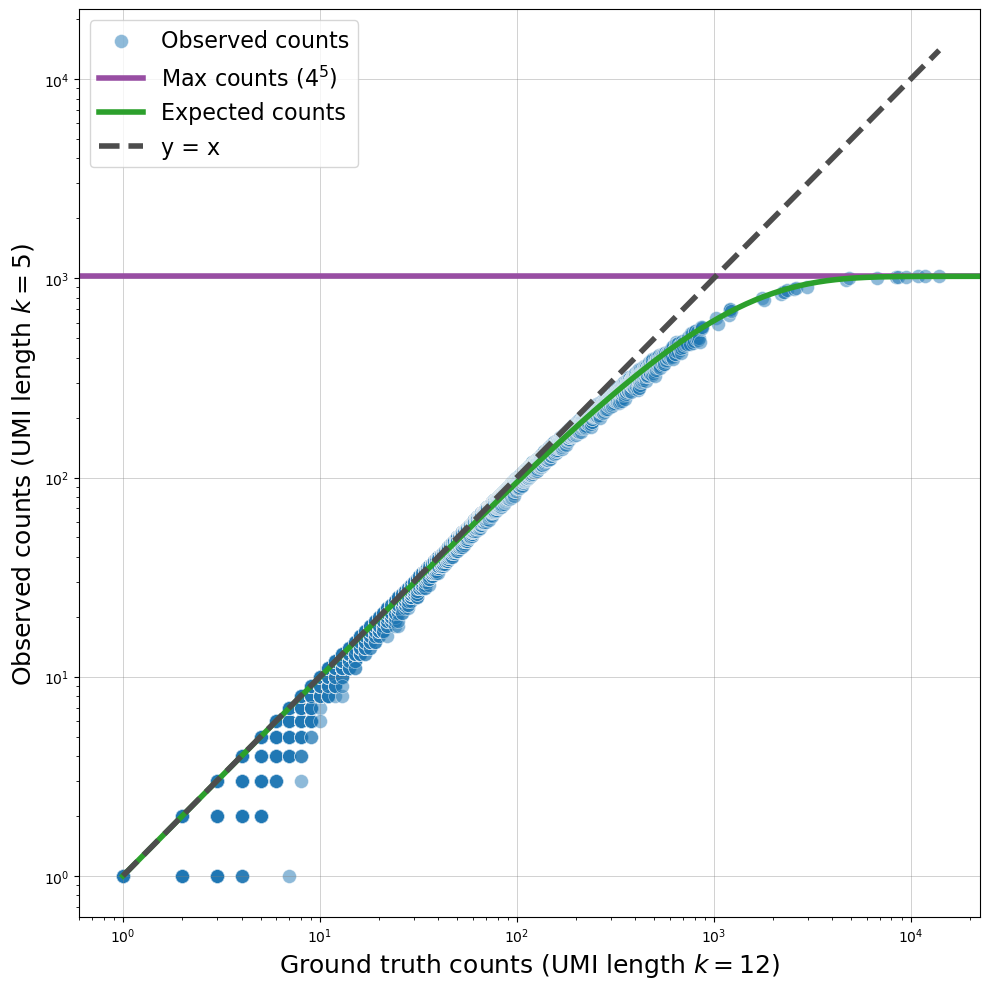

In [24]:
# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = [compute_non_unif_estimator(umi_prob_arr,n, j) for n in n_values]
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()

### Without the NPC genes

In [56]:
pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
npc_list = np.loadtxt("/data/dagyeman/cellranger/1k_non_protein_coding_genes.txt", dtype=str)
print(len(pc_list), len(npc_list))

19389 17205


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import time

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Prepare gene names and mask for filtered genes
genes = np.array(adata_dict[i].var_names)
print(len(genes), "genes in dataset i")

# Create a mask for the filtered genes (based on pc_list)
keep_genes_mask = np.isin(genes, pc_list)

# Subset adata objects by gene mask
adata_i_filtered = adata_dict[i][:, keep_genes_mask]
adata_j_filtered = adata_dict[j][:, keep_genes_mask]

# Get updated gene names
genes_filtered = np.array(adata_i_filtered.var_names)

# Prepare barcode index mapping
barcode_list = list(common_barcodes)
i_indices = [adata_i_filtered.obs_names.get_loc(b) for b in barcode_list]
j_indices = [adata_j_filtered.obs_names.get_loc(b) for b in barcode_list]

# Extract count matrices for common barcodes
X_i = adata_i_filtered.X[i_indices]
X_j = adata_j_filtered.X[j_indices]

# Mask for gene counts ≥ 1 in UMI-12 data
mask = X_i >= 1
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

# Sort the counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

Total common barcodes: 1232
28226 genes in dataset i


/tmp/ipykernel_3661160/1622388147.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e4)
/tmp/ipykernel_3661160/1622388147.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e4)


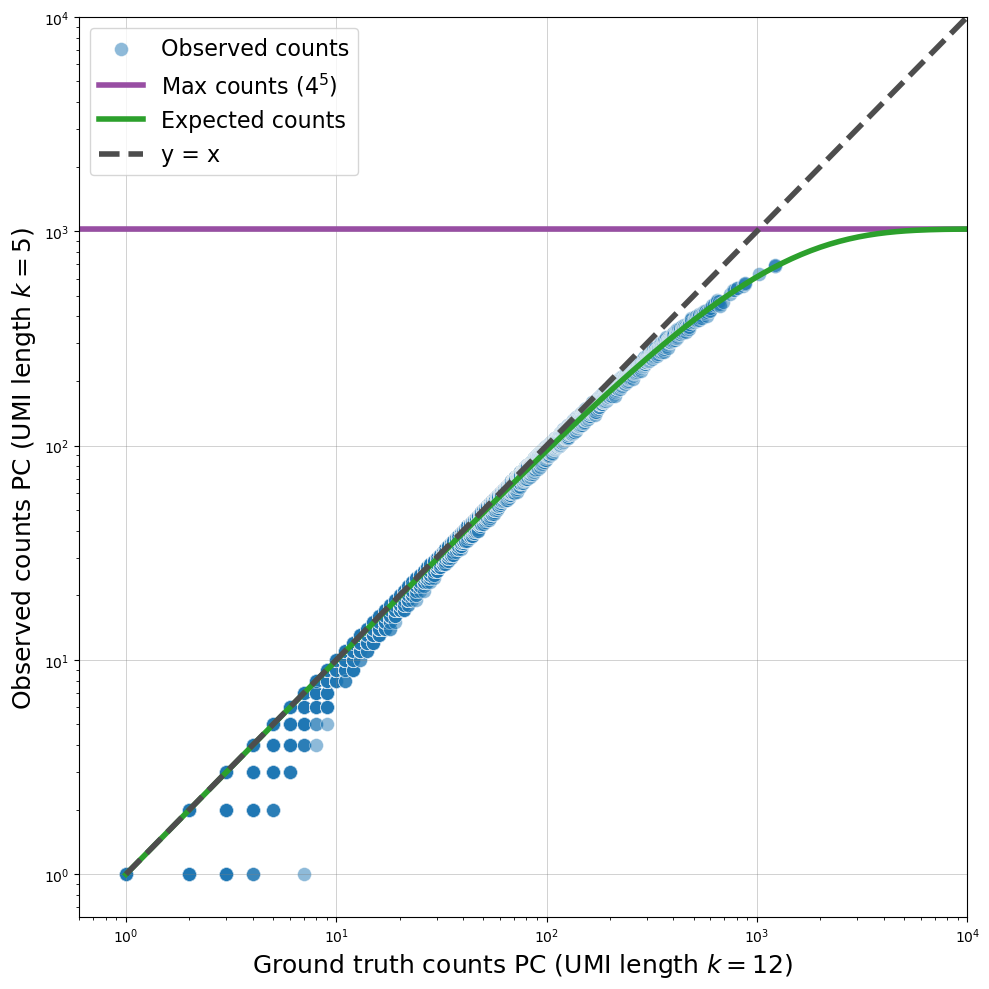

In [27]:
# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = [compute_non_unif_estimator(umi_prob_arr, n, j) for n in n_values]
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), 1e4)
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, 1e4)
plt.xlim(0, 1e4)
plt.ylabel(r"Observed counts PC (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts PC (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()

## Plots for the Inverted Estimator

In [32]:
def mom_estimator(prob_arr, values, j):
    """Inverts the model using the method of moments."""
    values = np.array(values)
    n_values = np.linspace(1, 60000, 60000)
   
    assert len(umi_prob_arr) == 4**j, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    f_hat_values = np.array([4**j - np.sum( (1-umi_prob_arr)**n ) for n in n_values])
    
    N_hat_values = []
    
    for y in values: 
        i = np.searchsorted(f_hat_values, y) -1
        i = np.clip(i, 0, len(f_hat_values) - 2)
        
        n_i = n_values[i]
        n_ip1 = n_values[i + 1]
        f_ni = f_hat_values[i]
        f_nip1 = f_hat_values[i + 1]
        
        N_hat = n_i + (y - f_ni) * (n_ip1 - n_i) / (f_nip1 - f_ni)
        N_hat_values.append(N_hat)
        
    return np.array(N_hat_values)
    
    
    
    
umi_probs = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=None)
umi_probs.columns = ['umi', 'prob']
umi_prob_arr = np.array(umi_probs['prob'])    
    
    
    
    
    

In [33]:
k=5
filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{k}.h5ad"
output_filepath = f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_{k}.h5ad"

adata = sc.read_h5ad(filepath)
original_matrix = adata.X.copy()  # If sparse, consider converting to dense with .toarray()

K_val = 4 ** k
predicted_gex = mom_estimator(umi_prob_arr, original_matrix, j)

new_adata = anndata.AnnData(X=predicted_gex, obs=adata.obs.copy(), var=adata.var.copy())
new_adata.write_h5ad(output_filepath)

print(f"New predicted gene expression matrix saved for UMI length {k} to: {output_filepath}")

New predicted gene expression matrix saved for UMI length 5 to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad


In [41]:
mask = predicted_gex > 5*10**4
print( original_matrix[mask], predicted_gex[mask])

[1024. 1024.] [62441.66666667 62441.66666667]


In [77]:
adata_inverted_5 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")



In [2]:
import numpy as np 
import scanpy as sc 
import anndata as ad
import pandas as pd

pc_list = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
npc_list = np.loadtxt("/data/dagyeman/cellranger/1k_non_protein_coding_genes.txt", dtype=str)

### All cell, all Genes

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

common_barcodes = set(adata_12.obs_names).intersection(set(adata_inverted_5.obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Extract gene matrix for common barcodes
genes = np.array(adata_12.var_names)
barcode_list = list(common_barcodes)
i_indices = [adata_12.obs_names.get_loc(b) for b in barcode_list]
j_indices = [adata_inverted_5.obs_names.get_loc(b) for b in barcode_list]

# Pull full matrices at once
X_i = adata_12.X[i_indices]
X_j = adata_inverted_5.X[j_indices]

# Create mask for gene_counts_i that are greater than or equal to 1
mask = X_i >= 1

# Filter using the mask
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays (already are, but for consistency)
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

Total common barcodes: 1232
Total filtered gene counts: 4283561


/tmp/ipykernel_3980440/649152644.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_3980440/649152644.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


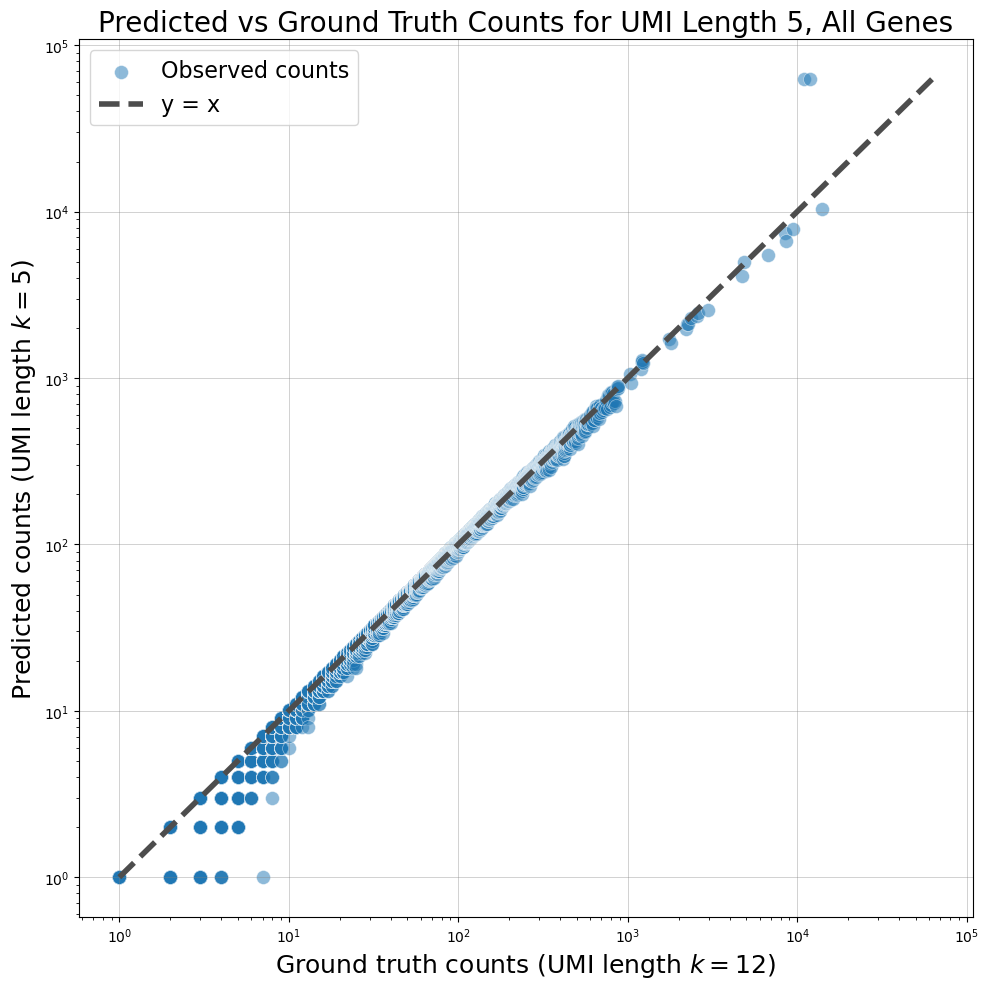

In [79]:
# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# # Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=4, 
#     label=f'Max counts ($4^{{{j}}}$)'
# )

# # Plot the model
# model_vals = [compute_non_unif_estimator(umi_prob_arr,n, j) for n in n_values]
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=4, 
#     label='Expected counts'
# )

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.title("Predicted vs Ground Truth Counts for UMI Length 5, All Genes", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

plt.tight_layout()

plt.show()
plt.close()

### Removing NPC from the genes

In [6]:
### NOTE: REMOVING JUST MALAT1
remove = np.array(["MALAT1"])

In [12]:
import numpy as np
import matplotlib.pyplot as plt

adata_inverted_5 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

common_barcodes = set(adata_12.obs_names).intersection(set(adata_inverted_5.obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")




barcode_list = list(common_barcodes)
indices_12 = [adata_12.obs_names.get_loc(b) for b in barcode_list]
indices_5 = [adata_inverted_5.obs_names.get_loc(b) for b in barcode_list]

# Pull full matrices at once
X_12 = adata_12.X[indices_12]
X_5 = adata_inverted_5.X[indices_5]

# Create mask for gene_counts_i that are greater than or equal to 1
mask = X_12 >= 1

# Filter using the mask
filtered_counts_12 = X_12[mask]
filtered_counts_5 = X_5[mask]

# Convert to numpy arrays (already are, but for consistency)
all_gene_counts_12 = np.array(filtered_counts_12)
all_gene_counts_5 = np.array(filtered_counts_5)

print(f"Total filtered gene counts: {len(all_gene_counts_12)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_12)
sorted_gene_counts_12 = all_gene_counts_12[sorted_indices]
sorted_gene_counts_5 = all_gene_counts_5[sorted_indices]

Total common barcodes: 1232
Total filtered gene counts: 4283561


/tmp/ipykernel_4011427/1256648551.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_4011427/1256648551.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


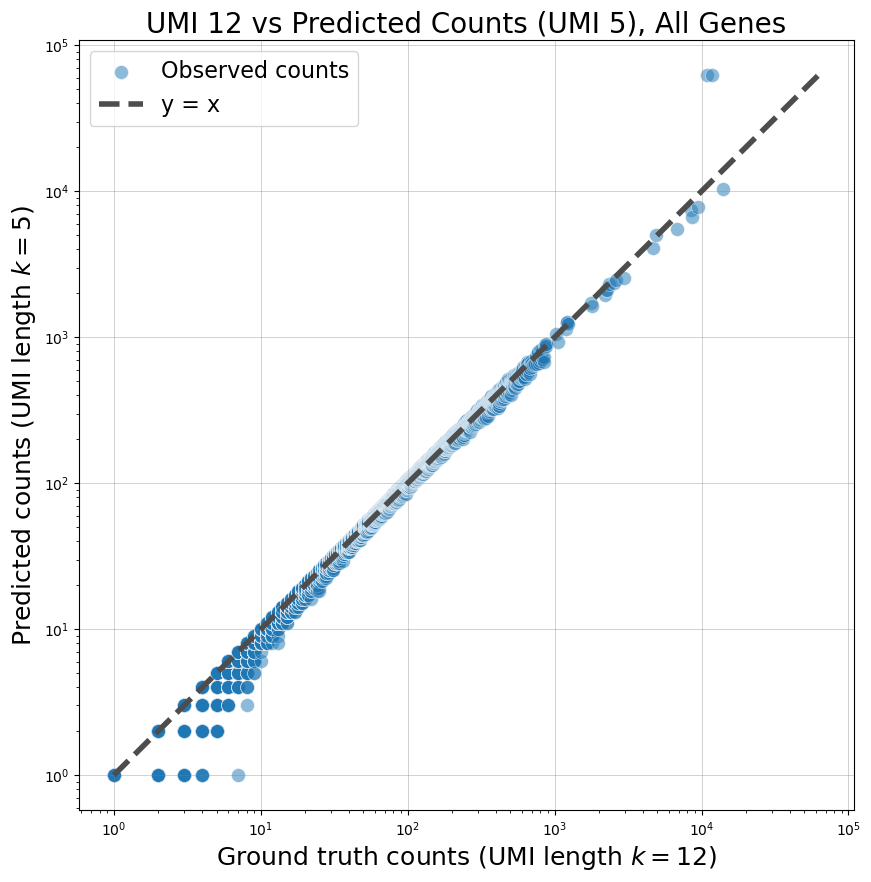

In [13]:
# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_12, 
    sorted_gene_counts_5, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# # Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=4, 
#     label=f'Max counts ($4^{{{j}}}$)'
# )

# # Plot the model
# model_vals = [compute_non_unif_estimator(umi_prob_arr,n, j) for n in n_values]
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=4, 
#     label='Expected counts'
# )

# Reference y = x line
max_val = max(sorted_gene_counts_12.max(), sorted_gene_counts_5.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position
if np.array_equal(g_type, pc_list):
    title = f"UMI 12 vs Predicted Counts (UMI {j}), Protein-Coding Genes"
elif np.array_equal(g_type, npc_list):
    title = f"UMI 12 vs Predicted Counts (UMI {j}), Non-Protein-Coding Genes"
elif np.array_equal(g_type, remove):
    title = f"UMI 12 vs Predicted Counts (UMI {j}), Without MALAT1"
else:
    title = f"UMI 12 vs Predicted Counts (UMI {j}), All Genes"

plt.title(title, fontsize=20)

plt.show()
plt.close()

### Residual Plots stuff

In [ ]:
######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

In [ ]:

###### Dylan initial plotting code

# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs



directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"  # Directory for 10k_PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 500 PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ur_objects/adata_matrices/"  # Directory for 500 PBMCs



# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    






# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Fixed comparison UMI length
# barcode = "TGTATCTCAGGAATCT-1" # 5k PBMCs 
# barcode = "CAGCAGCTCTCCAATT-1" # 500 PBMCs
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1



gene_counts_i = adata_dict[i].X.flatten()
gene_counts_j = adata_dict[j].X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))

# Compute colors based on condition
colors = ["red" if sorted_gene_counts_j[i] - f(sorted_gene_counts_j[i], j) < -40 else '#1f77b4' for i in range(len(sorted_gene_counts_i)) ]


plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16, loc = "upper left")
plt.tight_layout()

plt.show()

### Confusion Matrix Plot

In [ ]:
adata_inverted_5 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

In [ ]:
import scanpy as sc
import celltypist
import os


# common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices" # 1k
common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" # 10k
# Define file paths
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# # Process each UMI length
# for i in range(1, 13):
#     print(f"Processing UMI length: {i}")
    
#     # Load the h5ad file for the current UMI length
#     adata = sc.read_h5ad(filepath + f"/adata_inverted_{i}.h5ad")
    
#     # Normalize counts per cell to 10,000
#     sc.pp.normalize_total(adata, target_sum=1e4)
    
#     # Apply log1p transformation
#     sc.pp.log1p(adata)
    
#     # Check matrix sample (optional)
#     print(f"Sample of the matrix for UMI length {i}:")
#     print(adata.X[:5, :5])
#     print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
#     # Annotate the cell types using the CellTypist model
#     predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
#     # Store annotated data
#     annotated_adata = predictions.to_adata()
#     annotated_adata_dict[i] = annotated_adata
    
#     # Save annotated AnnData object
#     annotated_output_path = os.path.join(output_path, f"annotated_inv_matrices/annotated_adata_{i}.h5ad")
#     annotated_adata.write_h5ad(annotated_output_path)
#     print(f"Annotated data saved to: {annotated_output_path}\n")

#     # Compute UMAP
#     sc.tl.umap(annotated_adata)

#     # Plot UMAP with majority voting labels
#     sc.pl.umap(
#         annotated_adata, 
#         color=['majority_voting'], 
#         legend_loc='on data', 
#         title=f"UMAP for UMI length {i}(inverted)", 
#         show=True  # Display instead of saving


adata = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(f"Sample of the matrix for UMI length 5")
print(adata.X[:5, :5])
print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
predictions = celltypist.annotate(adata, model=model, majority_voting=True)
annotated_adata = predictions.to_adata()
sc.tl.umap(annotated_adata)

sc.pl.umap(
 annotated_adata, 
 color=['majority_voting'], 
 legend_loc='on data', 
 title=f"UMAP for UMI length {i}(inverted)", 
    \show=True  # Display instead of saving

In [1]:
import scanpy as sc
import celltypist
import os

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Load the h5ad file
adata = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/adata_inverted_5.h5ad")
# Normalize counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Apply log1p transformation
sc.pp.log1p(adata)

# Check matrix sample (optional)
print(f"Sample of the matrix for UMI length {i}:")
print(adata.X[:5, :5])
print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")

# Annotate the cell types using CellTypist
predictions = celltypist.annotate(adata, model=model, majority_voting=True)
annotated_adata = predictions.to_adata()

# Compute UMAP
sc.tl.umap(annotated_adata)

# Plot UMAP with majority voting labels
sc.pl.umap(
    annotated_adata, 
    color=['majority_voting'], 
    legend_loc='on data', 
    title=f"UMAP for UMI length {i} (inverted)", 
    show=True
)


ModuleNotFoundError: No module named 'celltypist'

In [ ]:
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")

max_val = adata_12.X.max()